# Imports

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Reading the Data

In [2]:
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data

def process_data(data):
    reviews = []
    labels = []
    embeddings = []

    for item in data:
        reviews.append(item["text"])
        if "label" in item:
            labels.append(item["label"])
        embeddings.append(item['embedding'])

    return reviews, labels, embeddings

def create_dataframe(reviews, labels, embeddings):
    obj = {
        'review': reviews,
        'embedding': embeddings
    }
    if len(labels) != 0:
        obj['label'] = labels
    df = pd.DataFrame(obj)
    return df

In [3]:
labeled_train_df = create_dataframe(
    *process_data(
        read_jsonl("imdb/train_imdb.jsonl")
    )
)
unlabled_train_df = create_dataframe(
    *process_data(
        read_jsonl("imdb/aug_imdb_unlabeled.jsonl")
    )
)
test_df = create_dataframe(
    *process_data(
        read_jsonl("imdb/test_imdb.jsonl")
    )
)

In [4]:
labeled_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     150 non-null    object
 1   embedding  150 non-null    object
 2   label      150 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 3.6+ KB


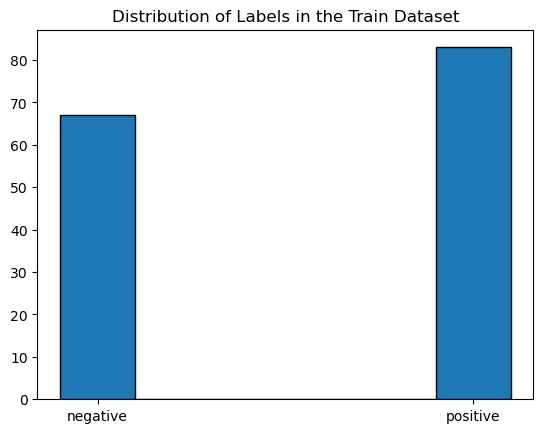

In [5]:
plt.hist(labeled_train_df['label'], bins=[-0.1, 0.1, 0.9, 1.1], edgecolor="black")
plt.title("Distribution of Labels in the Train Dataset")
plt.xticks([0, 1], labels=['negative', 'positive'])
plt.show()

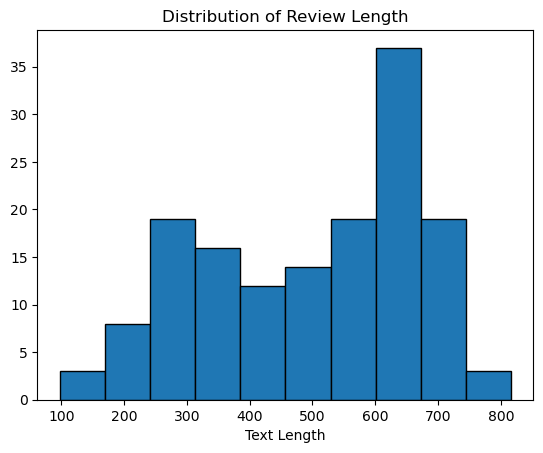

In [6]:
review_list = labeled_train_df['review']
text_len_dist = [ len(review) if review else 0 for review in review_list ]
plt.hist(text_len_dist, edgecolor="black")
plt.title("Distribution of Review Length")
plt.xlabel("Text Length")
plt.show()

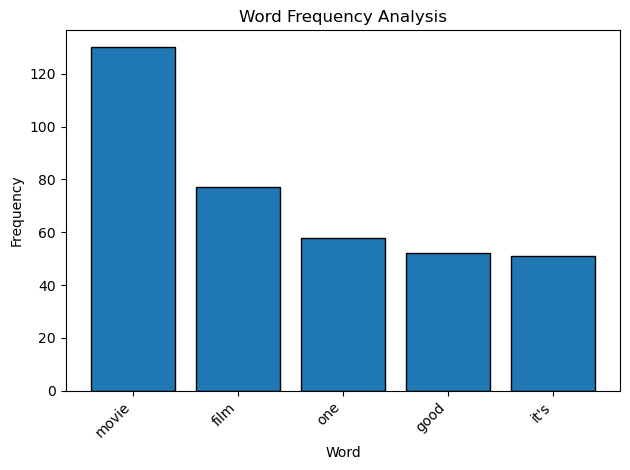

In [7]:
from collections import Counter

with open("stopwords.txt", 'r') as file:
        stopwords = [line.strip() for line in file]

tokens = [token.lower() for review in review_list \
          for token in review.replace("<br />", "").split() \
                if token.lower() not in stopwords  ]

token_counts = Counter(tokens)
top_tokens = dict(sorted(token_counts.items(), key=lambda x: x[1], reverse=True)[:5])

plt.bar(top_tokens.keys(), top_tokens.values(), edgecolor="black")
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Word Frequency Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

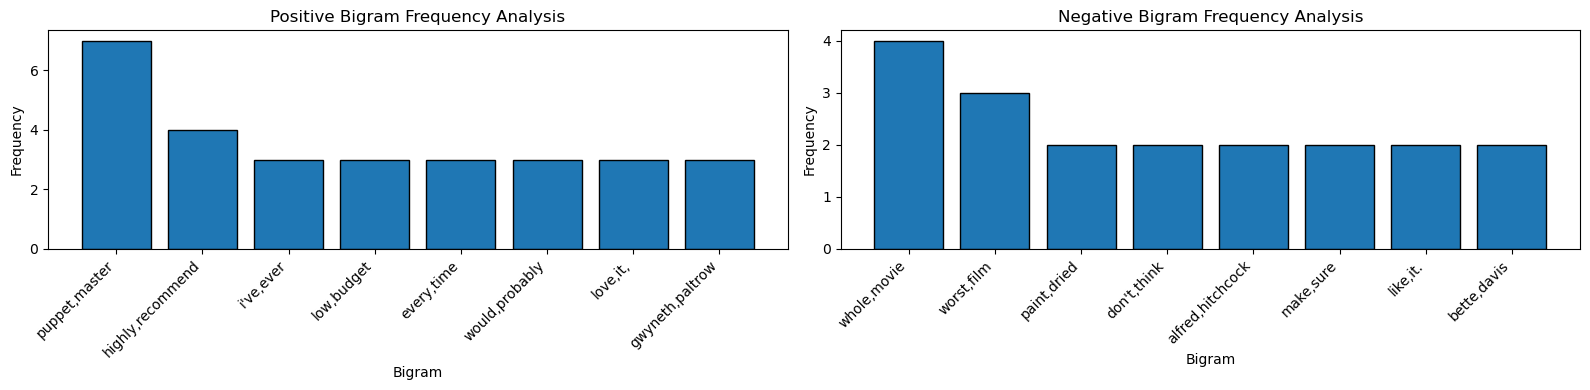

In [8]:
def preprocess(review):
    review = review.replace("<br />", "")
    tokens = list(review.lower().split())
    bigrams = [(tokens[i], tokens[i+1]) for i in range(len(tokens)-1) if tokens[i].lower() not in stopwords and tokens[i+1].lower() not in stopwords]
    return bigrams


positive_review_list = labeled_train_df[labeled_train_df['label'] == 1]['review'].tolist()
negative_review_list = labeled_train_df[labeled_train_df['label'] == 0]['review'].tolist()

positive_bigrams = [bigram for review in positive_review_list for bigram in preprocess(review)]
negative_bigrams = [bigram for review in negative_review_list for bigram in preprocess(review)]

positive_bigram_counts = Counter(positive_bigrams)
negative_bigram_counts = Counter(negative_bigrams)

positive_top_bigrams = dict(sorted(positive_bigram_counts.items(), key=lambda x: x[1], reverse=True)[:8])
negative_top_bigrams = dict(sorted(negative_bigram_counts.items(), key=lambda x: x[1], reverse=True)[:8])

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.bar([','.join(key) for key in positive_top_bigrams.keys()], positive_top_bigrams.values(), edgecolor="black")
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.title('Positive Bigram Frequency Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.bar([','.join(key) for key in negative_top_bigrams.keys()], negative_top_bigrams.values(), edgecolor="black")
plt.xlabel('Bigram')
plt.ylabel('Frequency')
plt.title('Negative Bigram Frequency Analysis')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Labeling the Unlabled Train Data

In [9]:
unlabled_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     1014 non-null   object
 1   embedding  1014 non-null   object
dtypes: object(2)
memory usage: 16.0+ KB


In [10]:
X_org = np.array([ np.array(entry) for entry in labeled_train_df['embedding'] ], dtype=np.float64)
y_org = np.array(labeled_train_df['label'], dtype=np.int16)

X_aug = np.array([ np.array(entry) for entry in unlabled_train_df['embedding'] ], dtype=np.float64)

X_test = np.array([ np.array(entry) for entry in test_df['embedding'] ], dtype=np.float64)
y_test = np.array(test_df['label'], dtype=np.int16)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def print_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_pred, y_test)
    precision = precision_score(y_pred, y_test)
    recall = recall_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)

    print(f"Model Accuracy: {accuracy}")
    print(f"Model Precision: {precision}")
    print(f"Model Recall: {recall}")
    print(f"Model F1-Score: {f1}")

In [12]:
def shuffle_dataset(X, y):
    permutation = np.random.permutation(len(y))

    X_shuffled = X[permutation]
    y_shuffled = y[permutation]
    return X_shuffled, y_shuffled

In [13]:
from sklearn.decomposition import PCA

X_org = np.array([ np.array(entry) for entry in labeled_train_df['embedding'] ], dtype=np.float64)
y_org = np.array(labeled_train_df['label'], dtype=np.int16)

X_org_reduced_train = np.concatenate([X_org, X_aug])

pca_transformer = PCA(n_components=0.75)
pca_transformer.fit(X_org_reduced_train)
X_org_reduced = pca_transformer.transform(X_org)
X_aug_reduced = pca_transformer.transform(X_aug)
X_test_reduced = pca_transformer.transform(X_test)

X_all_reduced = np.vstack((X_org_reduced, X_aug_reduced))
X_org.shape, X_org_reduced.shape, X_aug.shape, X_aug_reduced.shape

((150, 768), (150, 51), (1014, 768), (1014, 51))

### Manual Label Assignment

#### Random Forrest Classifier

##### Step 1

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.semi_supervised import SelfTrainingClassifier

X_org_reduced, y_org = shuffle_dataset(X_org_reduced, y_org)
X_org_reduced_train, X_org_reduced_validation, y_org_train, y_org_validation = train_test_split(X_org_reduced, y_org, test_size=0.2, random_state=42)

base_classifier = RandomForestClassifier(max_depth=15, max_features='log2', criterion='gini', n_estimators=300, max_leaf_nodes=4)
random_forrest_classifier_step1 = SelfTrainingClassifier(base_classifier, threshold=0.8, criterion='threshold')
random_forrest_classifier_step1.fit(np.vstack((X_org_reduced_train, X_aug_reduced)), np.concatenate((y_org_train, [-1]*len(X_aug_reduced))))

SelfTrainingClassifier(base_estimator=RandomForestClassifier(max_depth=15,
                                                             max_features='log2',
                                                             max_leaf_nodes=4,
                                                             n_estimators=300),
                       threshold=0.8)

In [15]:
print("On Train Data:")
print_metrics(random_forrest_classifier_step1, X_org_reduced_train, y_org_train)

print("On Validation Data:")
print_metrics(random_forrest_classifier_step1, X_org_reduced_validation, y_org_validation)

On Train Data:
Model Accuracy: 0.9833333333333333
Model Precision: 0.9841269841269841
Model Recall: 0.9841269841269841
Model F1-Score: 0.9841269841269841
On Validation Data:
Model Accuracy: 0.7666666666666667
Model Precision: 0.8
Model Recall: 0.8421052631578947
Model F1-Score: 0.8205128205128205


In [16]:
print("On Test Data")
print_metrics(random_forrest_classifier_step1, X_test_reduced, y_test)

On Test Data
Model Accuracy: 0.6933333333333334
Model Precision: 0.75
Model Recall: 0.6585365853658537
Model F1-Score: 0.7012987012987012


##### Step 2

In [17]:
y_aug = random_forrest_classifier_step1.predict(X_aug_reduced)
y_all = np.concatenate([y_org, y_aug])

X_all_reduced, y_all = shuffle_dataset(X_all_reduced, y_all)
X_all_reduced_train, X_all_reduced_validation, y_all_train, y_all_validation = train_test_split(X_all_reduced, y_all, test_size=0.2, random_state=42)

random_forrest_classifier_step2 = RandomForestClassifier(max_depth=15, max_features='log2', criterion='gini', n_estimators=300, max_leaf_nodes=4)

random_forrest_classifier_step2.fit(X_all_reduced_train, y_all_train)

RandomForestClassifier(max_depth=15, max_features='log2', max_leaf_nodes=4,
                       n_estimators=300)

In [18]:
print("On Train Data:")
print_metrics(random_forrest_classifier_step2, X_all_reduced_train, y_all_train)

print("On Validation Data:")
print_metrics(random_forrest_classifier_step2, X_all_reduced_validation, y_all_validation)

print("On Test Data:")
print_metrics(random_forrest_classifier_step2, X_test_reduced, y_test)

On Train Data:
Model Accuracy: 0.6766917293233082
Model Precision: 0.9857397504456328
Model Recall: 0.6536643026004728
Model F1-Score: 0.7860696517412935
On Validation Data:
Model Accuracy: 0.592274678111588
Model Precision: 1.0
Model Recall: 0.5681818181818182
Model F1-Score: 0.7246376811594203
On Test Data:
Model Accuracy: 0.5333333333333333
Model Precision: 0.9861111111111112
Model Recall: 0.5071428571428571
Model F1-Score: 0.6698113207547169


#### Gradient Boosting Classifier

##### Step 1

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.semi_supervised import SelfTrainingClassifier

X_org_reduced, y_org = shuffle_dataset(X_org_reduced, y_org)
X_org_reduced_train, X_org_reduced_validation, y_org_train, y_org_validation = train_test_split(X_org_reduced, y_org, test_size=0.2, random_state=42)

base_classifier = GradientBoostingClassifier(learning_rate=0.01, criterion='friedman_mse', max_depth=10, max_features='log2', max_leaf_nodes=4)
gradient_boosting_classifier_step1 = SelfTrainingClassifier(base_classifier, threshold=0.8, criterion='threshold')
gradient_boosting_classifier_step1.fit(np.vstack((X_org_reduced_train, X_aug_reduced)), np.concatenate((y_org_train, [-1]*len(X_aug_reduced))))

SelfTrainingClassifier(base_estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                                 max_depth=10,
                                                                 max_features='log2',
                                                                 max_leaf_nodes=4),
                       threshold=0.8)

In [20]:
print("On Train Data:")
print_metrics(gradient_boosting_classifier_step1, X_org_reduced_train, y_org_train)

print("On Validation Data:")
print_metrics(gradient_boosting_classifier_step1, X_org_reduced_validation, y_org_validation)

On Train Data:
Model Accuracy: 0.9916666666666667
Model Precision: 1.0
Model Recall: 0.9850746268656716
Model F1-Score: 0.9924812030075187
On Validation Data:
Model Accuracy: 0.6333333333333333
Model Precision: 0.8823529411764706
Model Recall: 0.625
Model F1-Score: 0.7317073170731708


In [21]:
print_metrics(gradient_boosting_classifier_step1, X_test_reduced, y_test)

Model Accuracy: 0.6933333333333334
Model Precision: 0.9166666666666666
Model Recall: 0.6226415094339622
Model F1-Score: 0.7415730337078651


##### Step 2

In [22]:
y_aug = gradient_boosting_classifier_step1.predict(X_aug_reduced)
y_all = np.concatenate([y_org, y_aug])

X_all_reduced, y_all = shuffle_dataset(X_all_reduced, y_all)
X_all_reduced_train, X_all_reduced_validation, y_all_train, y_all_validation = train_test_split(X_all_reduced, y_all, test_size=0.2, random_state=42)

gradient_boosting_classifier_step2 = GradientBoostingClassifier(learning_rate=0.01, criterion='squared_error', max_depth=10, max_features='log2', max_leaf_nodes=10)

gradient_boosting_classifier_step2.fit(X_all_reduced_train, y_all_train)

GradientBoostingClassifier(criterion='squared_error', learning_rate=0.01,
                           max_depth=10, max_features='log2',
                           max_leaf_nodes=10)

In [23]:
print("On Train Data:")
print_metrics(gradient_boosting_classifier_step2, X_all_reduced_train, y_all_train)

print("On Validation Data:")
print_metrics(gradient_boosting_classifier_step2, X_all_reduced_validation, y_all_validation)

print("On Test Data:")
print_metrics(gradient_boosting_classifier_step2, X_test_reduced, y_test)

On Train Data:
Model Accuracy: 0.7089151450053706
Model Precision: 1.0
Model Recall: 0.7086021505376344
Model F1-Score: 0.8294524858401511
On Validation Data:
Model Accuracy: 0.7854077253218884
Model Precision: 1.0
Model Recall: 0.7854077253218884
Model F1-Score: 0.8798076923076923
On Test Data:
Model Accuracy: 0.48
Model Precision: 1.0
Model Recall: 0.48
Model F1-Score: 0.6486486486486487


### Label Assignment Using LLM

In [24]:
y_aug_llm = pd.read_csv('llm_labels.csv', index_col=0)['label'].astype(str).apply(lambda x: (
    1 if x.strip().lower() == 'positive' else 
    0 if x.strip().lower() == 'negative' else 
    np.nan)
).to_numpy()

len(y_aug_llm), len(X_aug_reduced)

(1014, 1014)

In [28]:
y_all = np.concatenate([y_org, y_aug_llm])
y_all_filtered = y_all[~np.isnan(y_all)]
X_all_reduced_filtered = X_all_reduced[~np.isnan(y_all)]

X_all_reduced_filtered, y_all_filtered = shuffle_dataset(X_all_reduced_filtered, y_all_filtered)
X_all_reduced_filtered_train, X_all_reduced_filtered_validation, y_all_filtered_train, y_all_filtered_validation = train_test_split(X_all_reduced_filtered, y_all_filtered, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(max_depth=5, max_features='log2', criterion='entropy', n_estimators=1000, max_leaf_nodes=5)

classifier.fit(X_all_reduced_filtered_train, y_all_filtered_train)

RandomForestClassifier(criterion='entropy', max_depth=5, max_features='log2',
                       max_leaf_nodes=5, n_estimators=1000)

In [29]:
print("On Train Data:")
print_metrics(classifier, X_all_reduced_filtered_train, y_all_filtered_train)

print("On Validation Data:")
print_metrics(classifier, X_all_reduced_filtered_validation, y_all_filtered_validation)

print("On Test Data:")
print_metrics(classifier, X_test_reduced, y_test)

On Train Data:
Model Accuracy: 0.6544444444444445
Model Precision: 0.9978991596638656
Model Recall: 0.6050955414012739
Model F1-Score: 0.753370340999207
On Validation Data:
Model Accuracy: 0.5353982300884956
Model Precision: 0.9576271186440678
Model Recall: 0.5305164319248826
Model F1-Score: 0.6827794561933536
On Test Data:
Model Accuracy: 0.46
Model Precision: 0.9305555555555556
Model Recall: 0.46853146853146854
Model F1-Score: 0.6232558139534884
